# Quick glimpse viewer

In [2]:
import napari
import pandas as pd
import os, glob
import zarr
from tqdm.auto import tqdm
from macrohet import dataio, tile, visualise, notify
from datetime import datetime
current_date = datetime.now().strftime('%d-%m-%Y')
import btrack 
import cv2
import re
import time
import numpy as np

In [3]:
sc_df_fn = f'/mnt/SYNO/macrohet_syno/manuscript/results/sc_df.pkl'

In [4]:
df = pd.read_pickle(sc_df_fn)

In [5]:
df

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,Technical Replicate,Biological Replicate,Strain,Compound,Concentration,Cell ID,Acquisition ID,Experiment ID,Unique ID,ID
0,0.0,0.424621,-0.424621,459.082108,-92.746118,1.0,1.0,0.0,457.172943,8.791715,...,1,1,RD1,CTRL,EC0,426,"(3, 4)",PS0000,426.3.4,426.3.4.PS0000
1,1.0,0.000000,-0.424621,372.839393,-92.746118,0.0,1.0,0.0,459.138947,6.718642,...,1,1,RD1,CTRL,EC0,426,"(3, 4)",PS0000,426.3.4,426.3.4.PS0000
2,2.0,0.000000,-0.424621,423.168130,-92.746118,0.0,1.0,0.0,460.555237,10.785886,...,1,1,RD1,CTRL,EC0,426,"(3, 4)",PS0000,426.3.4,426.3.4.PS0000
3,3.0,0.335227,-0.424621,445.561289,-92.746118,1.0,1.0,0.0,455.878815,11.143067,...,1,1,RD1,CTRL,EC0,426,"(3, 4)",PS0000,426.3.4,426.3.4.PS0000
4,4.0,0.000000,-0.424621,487.040034,-92.746118,1.0,1.0,0.0,462.634186,14.050420,...,1,1,RD1,CTRL,EC0,426,"(3, 4)",PS0000,426.3.4,426.3.4.PS0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722130,74.5,1.117423,1.095075,752.584461,55.088959,1.0,1.0,1.0,227.093262,130.358139,...,2,3,RD1,BDQ,EC99,1874,"(6, 12)",ND0003,1874.6.12,1874.6.12.ND0003
1722131,75.0,2.033710,1.095075,616.035357,55.088959,1.0,1.0,1.0,226.622925,130.532120,...,2,3,RD1,BDQ,EC99,1874,"(6, 12)",ND0003,1874.6.12,1874.6.12.ND0003
1722132,75.5,1.430302,1.095075,579.182743,55.088959,1.0,1.0,1.0,225.366608,129.932709,...,2,3,RD1,BDQ,EC99,1874,"(6, 12)",ND0003,1874.6.12,1874.6.12.ND0003
1722133,76.0,1.989013,1.095075,679.147414,55.088959,1.0,1.0,1.0,226.424683,128.489410,...,2,3,RD1,BDQ,EC99,1874,"(6, 12)",ND0003,1874.6.12,1874.6.12.ND0003


In [6]:
crop_size = 750
track_scale_factor = 5.04
mask_outline = True
pattern = r"cell_ID\.(.*?)_dt"
pattern = r"cell_ID\.(.*?).mp4"
seg_fn = []
gfp_channel = 1
rfp_channel = 0
image_scale_m_per_pixel = 1.4949402023919043e-07
image_scale_um_per_pixel = image_scale_m_per_pixel*1E6
add_labels = True
boundary_buffer = 150
image_width = image_height = 6048

In [7]:
output_dirname = '/mnt/SYNO/macrohet_syno/manuscript/results/dt_dev/glimpses'

In [12]:
df[df['ID'] == '1985.4.4.ND0002']

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,Technical Replicate,Biological Replicate,Strain,Compound,Concentration,Cell ID,Acquisition ID,Experiment ID,Unique ID,ID
871036,28.0,0.000000,24.449218,1025.950849,302.218253,0.0,0.0,1.0,789.845337,623.157471,...,4,2,WT,CTRL,EC0,1985,"(4, 4)",ND0002,1985.4.4,1985.4.4.ND0002
871037,28.5,NaN,24.449218,NaN,302.218253,NaN,0.0,1.0,789.845337,623.157471,...,4,2,WT,CTRL,EC0,1985,"(4, 4)",ND0002,1985.4.4,1985.4.4.ND0002
871038,29.0,0.000000,24.449218,726.593199,302.218253,0.0,0.0,1.0,793.539062,631.953796,...,4,2,WT,CTRL,EC0,1985,"(4, 4)",ND0002,1985.4.4,1985.4.4.ND0002
871039,29.5,0.000000,24.449218,670.185681,302.218253,0.0,0.0,1.0,784.953552,633.485474,...,4,2,WT,CTRL,EC0,1985,"(4, 4)",ND0002,1985.4.4,1985.4.4.ND0002
871040,30.0,NaN,24.449218,NaN,302.218253,NaN,0.0,1.0,780.002563,633.417114,...,4,2,WT,CTRL,EC0,1985,"(4, 4)",ND0002,1985.4.4,1985.4.4.ND0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871104,62.0,NaN,24.449218,NaN,302.218253,NaN,0.0,1.0,799.682983,630.143188,...,4,2,WT,CTRL,EC0,1985,"(4, 4)",ND0002,1985.4.4,1985.4.4.ND0002
871105,62.5,17.655285,24.449218,1441.364062,302.218253,1.0,0.0,1.0,801.454224,618.879211,...,4,2,WT,CTRL,EC0,1985,"(4, 4)",ND0002,1985.4.4,1985.4.4.ND0002
871106,63.0,NaN,24.449218,NaN,302.218253,NaN,0.0,1.0,805.611328,622.381104,...,4,2,WT,CTRL,EC0,1985,"(4, 4)",ND0002,1985.4.4,1985.4.4.ND0002
871107,63.5,NaN,24.449218,NaN,302.218253,NaN,0.0,1.0,809.768433,625.882935,...,4,2,WT,CTRL,EC0,1985,"(4, 4)",ND0002,1985.4.4,1985.4.4.ND0002


In [28]:
ID = '1744.6.8.ND0003'

# set empty image array 
rgb_stack = []

# get single cell information 
sc_df = df[df['ID']==ID]


acq_ID = sc_df['Acquisition ID'].iloc[0] #  tuple(int(x) for x in ID.split('.')[1:3])
expt_ID = sc_df['Experiment ID'].iloc[0] #ID.split('.')[-1]
base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}'

# convert to frames
time_values = sc_df['Time (hours)']
if expt_ID != 'PS0000':
    frames = time_values*2 # if expt_ID != 'PS0000' else time_values
else:
    frames = time_values.values
# check channel enum
gfp_channel = 0 if expt_ID == 'PS0000' else 1
rfp_channel = 1 if expt_ID == 'PS0000' else 0

# load images
image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
zarr_group = zarr.open(image_dir, mode='r')
images = zarr_group.images

# check if segmentation already loaded
if str(acq_ID) not in seg_fn:
    # define seg path
    if expt_ID == 'PS0000':
        seg_fn = os.path.join(base_dir, f'labels/macrohet_seg_model/{acq_ID}.h5')
    else:
        seg_fn = os.path.join(base_dir, f'labels/cpv3/{acq_ID}.h5')
    # load segmentation
    with btrack.io.HDF5FileHandler(seg_fn,
                                   'r',
                                   obj_type='obj_type_1') as reader:
        segmentation = reader.segmentation
gfp_stack, rfp_stack = [], []
# iterate over time values creating
for t, frame_number in tqdm(zip(time_values, frames), total = len(frames)):
    # # set to int
    # t = int(t)
    frame_number = int(frame_number)
    # get precise time point information 
    sc_df_t = sc_df[sc_df['Time (hours)'] == t]
    # Extract xy coordinates and transpose for python and area from the cell information
    y_coord, x_coord, area, t = sc_df_t.loc[:, ['x', 'y', 'Mphi Area (µm)', 'Time (hours)']].values[0]
    # Scale according to tracking shrinkage
    y_coord, x_coord = y_coord * track_scale_factor, x_coord * track_scale_factor

    if not crop_size:
        # Calculate the side length for cropping based on the square root of the area
        crop_size = int(np.sqrt(area)) * 2

    # Calculate the cropping boundaries
    x_start = int(x_coord - crop_size / 2)
    x_end = int(x_coord + crop_size / 2)
    y_start = int(y_coord - crop_size / 2)
    y_end = int(y_coord + crop_size / 2)
    # Pad the boundaries if they exceed the image dimensions
    if x_start < 0:
        x_pad = abs(x_start)
        x_start = 0
    else:
        x_pad = 0

    if x_end > images.shape[-1]:
        x_pad_end = x_end - images.shape[-1]
        x_end = images.shape[-1]
    else:
        x_pad_end = 0

    if y_start < 0:
        y_pad = abs(y_start)
        y_start = 0
    else:
        y_pad = 0

    if y_end > images.shape[-2]:
        y_pad_end = y_end - images.shape[-2]
        y_end = images.shape[-2]
    else:
        y_pad_end = 0

    # Crop the image
    cropped_image = images[frame_number, ..., x_start:x_end, y_start:y_end]
    # max projection 
    cropped_image = np.max(images[frame_number, ..., x_start:x_end, y_start:y_end], axis = 1)
    # Pad the cropped image if necessary
    cropped_image = np.pad(cropped_image, ((0, 0), (x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')
    
    # extract the gfp and rfp channels to apply some vis techn
    gfp = cropped_image[gfp_channel, ...]#.compute().compute()
    rfp = cropped_image[rfp_channel, ...]#.compute().compute()
    gfp_stack.append(gfp)
    rfp_stack.append(rfp)
    # clip the images so that the contrast is more apparent
    contrast_lim_gfp = np.clip(gfp, 358, 5886)
    contrast_lim_rfp = np.clip(rfp, 480, 1300)

    norm_gfp = cv2.normalize(contrast_lim_gfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    norm_rfp = cv2.normalize(contrast_lim_rfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)

    # put the modified gfp rfp back in place
    cropped_image[gfp_channel, ...] = norm_gfp
    cropped_image[rfp_channel, ...] = norm_rfp

    # Create an empty RGB image with the same shape as the input image
    rgb_image = np.zeros((cropped_image.shape[1], cropped_image.shape[2], 3), dtype=np.uint16)

    # Assign the first channel to the green channel of the RGB image
    rgb_image[:, :, 1] = cropped_image[gfp_channel]

    # Assign the second channel to the red and blue channels of the RGB image to create magenta
    rgb_image[:, :, 0] = cropped_image[rfp_channel]
    rgb_image[:, :, 2] = cropped_image[rfp_channel]
    
    # scale down to 8bit
    rgb_image = np.uint8(rgb_image >> 8)
    
    if mask_outline:
        # load mask (singular)
        
        cropped_masks = segmentation[frame_number, x_start:x_end, y_start:y_end]
        
        # Pad the cropped image if necessary
        cropped_masks = np.pad(cropped_masks, ((x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')

        # extract only that segment
        seg_ID = cropped_masks[int(cropped_masks.shape[0] / 2), int(cropped_masks.shape[1] / 2)]
        
        if seg_ID == 0:
            instance_mask = np.zeros((crop_size, crop_size), dtype = np.uint8)
        else:
            instance_mask = (cropped_masks == seg_ID).astype(np.uint8)

        # draw outline
        contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(rgb_image, contours, -1, (0, 2 ** 8, 2 ** 8), thickness=2)  # make 8bit

    # # downsize image to reduce storage demands
    # rgb_image = cv2.resize(rgb_image, (rgb_image.shape[1] // 2, rgb_image.shape[0] // 2))
    
    # add labels 
    if add_labels:
        # Add text overlay
        text_color = (255, 255, 0)  # Cyan color in BGR format
        font_scale = 1.2
        font_thickness = 2
        text_thickness = 1
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # Bottom left corner text
        bottom_left_text = f"{t}hr"
        cv2.putText(rgb_image, bottom_left_text, (10, rgb_image.shape[0] - 20),
                    font, font_scale, text_color, font_thickness)
        
        # Bottom right corner text
        bottom_right_text = scale_bar_text = '20mu'
        text_size = cv2.getTextSize(bottom_right_text, font, font_scale, text_thickness)[0]
        bottom_right_text_position = (rgb_image.shape[1] - text_size[0] - 40, rgb_image.shape[0] - 20)
        cv2.putText(rgb_image, bottom_right_text, bottom_right_text_position,
                    font, font_scale, text_color, font_thickness)
        
        # Calculate line length in pixels for a 20 micrometer scale bar
        micrometer_scale_bar_length = 20
        line_length_pixels = int(micrometer_scale_bar_length / image_scale_um_per_pixel)
        
        # Draw line under bottom right text
        line_color = (255, 255, 0)  # Yellow color in BGR format
        line_thickness = 2
        line_start = (bottom_right_text_position[0], bottom_right_text_position[1] + 5)  # Adjusted by 5 pixels
        line_end = (line_start[0] + line_length_pixels, line_start[1])
        cv2.line(rgb_image, line_start, line_end,
                 line_color, line_thickness)
        
        # Top left corner text
        top_left_variable1 = ID
        cv2.putText(rgb_image, top_left_variable1, (10, 30),
                    font, font_scale, text_color, font_thickness)
        
        # Top right corner text
        mtb_value = sc_df_t['Mtb Area (µm)'].iloc[0]
        mtb_value = f"{mtb_value:.2f}mu sq"
        text_size = cv2.getTextSize(mtb_value, font, font_scale, text_thickness)[0]
        cv2.putText(rgb_image, mtb_value, (rgb_image.shape[1] - text_size[0] - 10, 30),
                    font, font_scale, text_color, font_thickness)

    
    rgb_stack.append(rgb_image)

max_height = max(rgb_image.shape[0] for rgb_image in rgb_stack)
max_width = max(rgb_image.shape[1] for rgb_image in rgb_stack)

# Resize each image to the maximum dimensions
resized_rgb_stack = [cv2.resize(rgb_image, (max_width, max_height)) for rgb_image in rgb_stack]

# Stack the resized images
rgb_stack = np.stack(resized_rgb_stack, axis=0)
# Get the dimensions of the first frame
height, width, _ = rgb_stack[0].shape

# Define the frame rate (number of frames per second)
frame_rate = len(rgb_stack) / 20  # Total frames divided by total seconds
## hacky fix to put outside of subdir
output_file = os.path.join(output_dirname, f'cell_ID.{ID}.mp4')
# output_file = f"/mnt/SYNO/macrohet_syno/manuscript/results/dt_dev_{current_date}/glimpses/{ID}_wmask.mp4"
# Initialize VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_file, fourcc, frame_rate, (width, height))

# Write each frame to the video file
for frame in rgb_stack:
    out.write(frame)

# Release the VideoWriter object
out.release()

print(f"Video {ID} saved successfully.")

[INFO][2024/04/22 04:21:03 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 8).h5...
[INFO][2024/04/22 04:21:28 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/04/22 04:21:28 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 8).h5


  0%|          | 0/113 [00:00<?, ?it/s]

Video 1744.6.8.ND0003 saved successfully.


In [29]:
ID = '350.4.3.ND0003'

# set empty image array 
rgb_stack = []

# get single cell information 
sc_df = df[df['ID']==ID]


acq_ID = sc_df['Acquisition ID'].iloc[0] #  tuple(int(x) for x in ID.split('.')[1:3])
expt_ID = sc_df['Experiment ID'].iloc[0] #ID.split('.')[-1]
base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}'

# convert to frames
time_values = sc_df['Time (hours)']
if expt_ID != 'PS0000':
    frames = time_values*2 # if expt_ID != 'PS0000' else time_values
else:
    frames = time_values.values
# check channel enum
gfp_channel = 0 if expt_ID == 'PS0000' else 1
rfp_channel = 1 if expt_ID == 'PS0000' else 0

# load images
image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
zarr_group = zarr.open(image_dir, mode='r')
images = zarr_group.images

# check if segmentation already loaded
if str(acq_ID) not in seg_fn:
    # define seg path
    if expt_ID == 'PS0000':
        seg_fn = os.path.join(base_dir, f'labels/macrohet_seg_model/{acq_ID}.h5')
    else:
        seg_fn = os.path.join(base_dir, f'labels/cpv3/{acq_ID}.h5')
    # load segmentation
    with btrack.io.HDF5FileHandler(seg_fn,
                                   'r',
                                   obj_type='obj_type_1') as reader:
        segmentation = reader.segmentation
gfp_stack, rfp_stack = [], []
# iterate over time values creating
for t, frame_number in tqdm(zip(time_values, frames), total = len(frames)):
    # # set to int
    # t = int(t)
    frame_number = int(frame_number)
    # get precise time point information 
    sc_df_t = sc_df[sc_df['Time (hours)'] == t]
    # Extract xy coordinates and transpose for python and area from the cell information
    y_coord, x_coord, area, t = sc_df_t.loc[:, ['x', 'y', 'Mphi Area (µm)', 'Time (hours)']].values[0]
    # Scale according to tracking shrinkage
    y_coord, x_coord = y_coord * track_scale_factor, x_coord * track_scale_factor

    if not crop_size:
        # Calculate the side length for cropping based on the square root of the area
        crop_size = int(np.sqrt(area)) * 2

    # Calculate the cropping boundaries
    x_start = int(x_coord - crop_size / 2)
    x_end = int(x_coord + crop_size / 2)
    y_start = int(y_coord - crop_size / 2)
    y_end = int(y_coord + crop_size / 2)
    # Pad the boundaries if they exceed the image dimensions
    if x_start < 0:
        x_pad = abs(x_start)
        x_start = 0
    else:
        x_pad = 0

    if x_end > images.shape[-1]:
        x_pad_end = x_end - images.shape[-1]
        x_end = images.shape[-1]
    else:
        x_pad_end = 0

    if y_start < 0:
        y_pad = abs(y_start)
        y_start = 0
    else:
        y_pad = 0

    if y_end > images.shape[-2]:
        y_pad_end = y_end - images.shape[-2]
        y_end = images.shape[-2]
    else:
        y_pad_end = 0

    # Crop the image
    cropped_image = images[frame_number, ..., x_start:x_end, y_start:y_end]
    # max projection 
    cropped_image = np.max(images[frame_number, ..., x_start:x_end, y_start:y_end], axis = 1)
    # Pad the cropped image if necessary
    cropped_image = np.pad(cropped_image, ((0, 0), (x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')
    
    # extract the gfp and rfp channels to apply some vis techn
    gfp = cropped_image[gfp_channel, ...]#.compute().compute()
    rfp = cropped_image[rfp_channel, ...]#.compute().compute()
    gfp_stack.append(gfp)
    rfp_stack.append(rfp)
    # clip the images so that the contrast is more apparent
    contrast_lim_gfp = np.clip(gfp, 358, 5886)
    contrast_lim_rfp = np.clip(rfp, 480, 1300)

    norm_gfp = cv2.normalize(contrast_lim_gfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    norm_rfp = cv2.normalize(contrast_lim_rfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)

    # put the modified gfp rfp back in place
    cropped_image[gfp_channel, ...] = norm_gfp
    cropped_image[rfp_channel, ...] = norm_rfp

    # Create an empty RGB image with the same shape as the input image
    rgb_image = np.zeros((cropped_image.shape[1], cropped_image.shape[2], 3), dtype=np.uint16)

    # Assign the first channel to the green channel of the RGB image
    rgb_image[:, :, 1] = cropped_image[gfp_channel]

    # Assign the second channel to the red and blue channels of the RGB image to create magenta
    rgb_image[:, :, 0] = cropped_image[rfp_channel]
    rgb_image[:, :, 2] = cropped_image[rfp_channel]
    
    # scale down to 8bit
    rgb_image = np.uint8(rgb_image >> 8)
    
    if mask_outline:
        # load mask (singular)
        
        cropped_masks = segmentation[frame_number, x_start:x_end, y_start:y_end]
        
        # Pad the cropped image if necessary
        cropped_masks = np.pad(cropped_masks, ((x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')

        # extract only that segment
        seg_ID = cropped_masks[int(cropped_masks.shape[0] / 2), int(cropped_masks.shape[1] / 2)]
        
        if seg_ID == 0:
            instance_mask = np.zeros((crop_size, crop_size), dtype = np.uint8)
        else:
            instance_mask = (cropped_masks == seg_ID).astype(np.uint8)

        # draw outline
        contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(rgb_image, contours, -1, (0, 2 ** 8, 2 ** 8), thickness=2)  # make 8bit

    # # downsize image to reduce storage demands
    # rgb_image = cv2.resize(rgb_image, (rgb_image.shape[1] // 2, rgb_image.shape[0] // 2))
    
    # add labels 
    if add_labels:
        # Add text overlay
        text_color = (255, 255, 0)  # Cyan color in BGR format
        font_scale = 1.2
        font_thickness = 2
        text_thickness = 1
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # Bottom left corner text
        bottom_left_text = f"{t}hr"
        cv2.putText(rgb_image, bottom_left_text, (10, rgb_image.shape[0] - 20),
                    font, font_scale, text_color, font_thickness)
        
        # Bottom right corner text
        bottom_right_text = scale_bar_text = '20mu'
        text_size = cv2.getTextSize(bottom_right_text, font, font_scale, text_thickness)[0]
        bottom_right_text_position = (rgb_image.shape[1] - text_size[0] - 40, rgb_image.shape[0] - 20)
        cv2.putText(rgb_image, bottom_right_text, bottom_right_text_position,
                    font, font_scale, text_color, font_thickness)
        
        # Calculate line length in pixels for a 20 micrometer scale bar
        micrometer_scale_bar_length = 20
        line_length_pixels = int(micrometer_scale_bar_length / image_scale_um_per_pixel)
        
        # Draw line under bottom right text
        line_color = (255, 255, 0)  # Yellow color in BGR format
        line_thickness = 2
        line_start = (bottom_right_text_position[0], bottom_right_text_position[1] + 5)  # Adjusted by 5 pixels
        line_end = (line_start[0] + line_length_pixels, line_start[1])
        cv2.line(rgb_image, line_start, line_end,
                 line_color, line_thickness)
        
        # Top left corner text
        top_left_variable1 = ID
        cv2.putText(rgb_image, top_left_variable1, (10, 30),
                    font, font_scale, text_color, font_thickness)
        
        # Top right corner text
        mtb_value = sc_df_t['Mtb Area (µm)'].iloc[0]
        mtb_value = f"{mtb_value:.2f}mu sq"
        text_size = cv2.getTextSize(mtb_value, font, font_scale, text_thickness)[0]
        cv2.putText(rgb_image, mtb_value, (rgb_image.shape[1] - text_size[0] - 10, 30),
                    font, font_scale, text_color, font_thickness)

    
    rgb_stack.append(rgb_image)

max_height = max(rgb_image.shape[0] for rgb_image in rgb_stack)
max_width = max(rgb_image.shape[1] for rgb_image in rgb_stack)

# Resize each image to the maximum dimensions
resized_rgb_stack = [cv2.resize(rgb_image, (max_width, max_height)) for rgb_image in rgb_stack]

# Stack the resized images
rgb_stack = np.stack(resized_rgb_stack, axis=0)
# Get the dimensions of the first frame
height, width, _ = rgb_stack[0].shape

# Define the frame rate (number of frames per second)
frame_rate = len(rgb_stack) / 20  # Total frames divided by total seconds
## hacky fix to put outside of subdir
output_file = os.path.join(output_dirname, f'cell_ID.{ID}.mp4')
# output_file = f"/mnt/SYNO/macrohet_syno/manuscript/results/dt_dev_{current_date}/glimpses/{ID}_wmask.mp4"
# Initialize VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_file, fourcc, frame_rate, (width, height))

# Write each frame to the video file
for frame in rgb_stack:
    out.write(frame)

# Release the VideoWriter object
out.release()

print(f"Video {ID} saved successfully.")

[INFO][2024/04/22 04:27:42 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 3).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 3).h5...
[INFO][2024/04/22 04:28:02 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/04/22 04:28:02 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 3).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 3).h5


  0%|          | 0/154 [00:00<?, ?it/s]

Video 350.4.3.ND0003 saved successfully.


In [22]:
m

KeyError: 'Experiment ID'

In [23]:
base_dir = f'/mnt/SYNO/macrohet_syno/ND0003'
image_dir = os.path.join(base_dir, f'acquisition/zarr/(6, 3).zarr')
zarr_group = zarr.open(image_dir, mode='r')
images = zarr_group.images

In [24]:
%%time
loaded_images = images[...]

CPU times: user 30.3 s, sys: 6min 51s, total: 7min 21s
Wall time: 2min 30s


In [25]:
loaded_images.shape

(154, 2, 3, 6048, 6048)

In [26]:
viewer = napari.Viewer()

viewer.add_image(loaded_images, channel_axis=1)
# viewer.add_image(rfp)

[<Image layer 'Image' at 0x7f66f07b0940>,
 <Image layer 'Image [1]' at 0x7f68b15e4dc0>]

In [ ]:
rgb_stack.shape

In [27]:
viewer.add_image(rgb_stack, channel_axis = -1)

[<Image layer 'Image' at 0x7fb5ef8ee640>,
 <Image layer 'Image [1]' at 0x7fb3f8e62940>,
 <Image layer 'Image [2]' at 0x7fb3e07827f0>]

In [61]:
loaded_images.shape

(92, 2, 3, 6048, 6048)

In [72]:
images.path


'images'

In [64]:
images.attrs['Expt. ID']

KeyError: 'Expt. ID'

In [23]:
%%time
loaded_images = images[31:123,...]

CPU times: user 16 s, sys: 3min 54s, total: 4min 10s
Wall time: 4min 36s


In [22]:
time_values*2

913783     31.0
913784     32.0
913785     33.0
913786     34.0
913787     35.0
          ...  
913871    119.0
913872    120.0
913873    121.0
913874    122.0
913875    123.0
Name: Time (hours), Length: 93, dtype: float64

In [18]:
output_file

'/mnt/SYNO/macrohet_syno/manuscript/results/dt_dev/glimpses/glimpses/cell_ID.622.4.12.ND0002.mp4'

In [33]:
sc_df['Acquisition ID'] 

142406    (4, 9)
142407    (4, 9)
142408    (4, 9)
142409    (4, 9)
142410    (4, 9)
           ...  
142476    (4, 9)
142477    (4, 9)
142478    (4, 9)
142479    (4, 9)
142480    (4, 9)
Name: Acquisition ID, Length: 75, dtype: object

In [46]:
df[df['ID'] == '299.4.5.PS0000']

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,Technical Replicate,Biological Replicate,Strain,Compound,Concentration,Cell ID,Acquisition ID,Experiment ID,Unique ID,ID
96990,0.0,5.207192,54.239717,559.449051,-268.606166,1.0,1.0,1.0,1084.301270,1045.057373,...,2,1,WT,CTRL,EC0,299,"(4, 5)",PS0000,299.4.5,299.4.5.PS0000
96991,1.0,5.296586,54.239717,525.814616,-268.606166,1.0,1.0,1.0,1073.122559,1049.332642,...,2,1,WT,CTRL,EC0,299,"(4, 5)",PS0000,299.4.5,299.4.5.PS0000
96992,2.0,8.581809,54.239717,547.425579,-268.606166,1.0,1.0,1.0,1068.232544,1045.764038,...,2,1,WT,CTRL,EC0,299,"(4, 5)",PS0000,299.4.5,299.4.5.PS0000
96993,3.0,9.118173,54.239717,548.185427,-268.606166,1.0,1.0,1.0,1066.336670,1047.029785,...,2,1,WT,CTRL,EC0,299,"(4, 5)",PS0000,299.4.5,299.4.5.PS0000
96994,4.0,8.894688,54.239717,528.809310,-268.606166,1.0,1.0,1.0,1067.974854,1049.129272,...,2,1,WT,CTRL,EC0,299,"(4, 5)",PS0000,299.4.5,299.4.5.PS0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97057,67.0,58.038956,54.239717,1033.482281,-268.606166,1.0,1.0,1.0,1049.211182,1054.809814,...,2,1,WT,CTRL,EC0,299,"(4, 5)",PS0000,299.4.5,299.4.5.PS0000
97058,68.0,59.983272,54.239717,1067.809519,-268.606166,1.0,1.0,1.0,1053.515381,1053.024902,...,2,1,WT,CTRL,EC0,299,"(4, 5)",PS0000,299.4.5,299.4.5.PS0000
97059,69.0,66.240842,54.239717,976.024385,-268.606166,1.0,1.0,1.0,1060.022095,1051.716187,...,2,1,WT,CTRL,EC0,299,"(4, 5)",PS0000,299.4.5,299.4.5.PS0000
97060,70.0,58.329486,54.239717,516.249474,-268.606166,1.0,1.0,1.0,1055.903564,1049.080933,...,2,1,WT,CTRL,EC0,299,"(4, 5)",PS0000,299.4.5,299.4.5.PS0000


In [49]:
df[df['ID'] == '330.3.5.PS0000']

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,Technical Replicate,Biological Replicate,Strain,Compound,Concentration,Cell ID,Acquisition ID,Experiment ID,Unique ID,ID
15830,0.0,24.426869,194.252832,1465.053345,69.771899,1.0,1.0,1.0,436.527710,282.877838,...,1,1,WT,CTRL,EC0,330,"(3, 5)",PS0000,330.3.5,330.3.5.PS0000
15831,1.0,21.387478,194.252832,1223.421875,69.771899,1.0,1.0,1.0,436.195770,285.880676,...,1,1,WT,CTRL,EC0,330,"(3, 5)",PS0000,330.3.5,330.3.5.PS0000
15832,2.0,25.276111,194.252832,1343.544800,69.771899,1.0,1.0,1.0,439.917786,282.430939,...,1,1,WT,CTRL,EC0,330,"(3, 5)",PS0000,330.3.5,330.3.5.PS0000
15833,3.0,25.499595,194.252832,1373.581177,69.771899,1.0,1.0,1.0,442.796906,282.465057,...,1,1,WT,CTRL,EC0,330,"(3, 5)",PS0000,330.3.5,330.3.5.PS0000
15834,4.0,25.119671,194.252832,1499.559448,69.771899,1.0,1.0,1.0,449.646851,278.126862,...,1,1,WT,CTRL,EC0,330,"(3, 5)",PS0000,330.3.5,330.3.5.PS0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15900,70.0,207.818349,194.252832,1583.656738,69.771899,1.0,1.0,1.0,443.267365,300.935425,...,1,1,WT,CTRL,EC0,330,"(3, 5)",PS0000,330.3.5,330.3.5.PS0000
15901,71.0,216.891825,194.252832,1716.942871,69.771899,1.0,1.0,1.0,442.532471,300.212036,...,1,1,WT,CTRL,EC0,330,"(3, 5)",PS0000,330.3.5,330.3.5.PS0000
15902,72.0,222.568334,194.252832,1627.750244,69.771899,1.0,1.0,1.0,442.456696,300.875275,...,1,1,WT,CTRL,EC0,330,"(3, 5)",PS0000,330.3.5,330.3.5.PS0000
15903,73.0,214.791069,194.252832,1720.965698,69.771899,1.0,1.0,1.0,441.769745,300.604919,...,1,1,WT,CTRL,EC0,330,"(3, 5)",PS0000,330.3.5,330.3.5.PS0000


In [52]:
import seaborn as sns

/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dayn/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Mtb Area (µm)'>

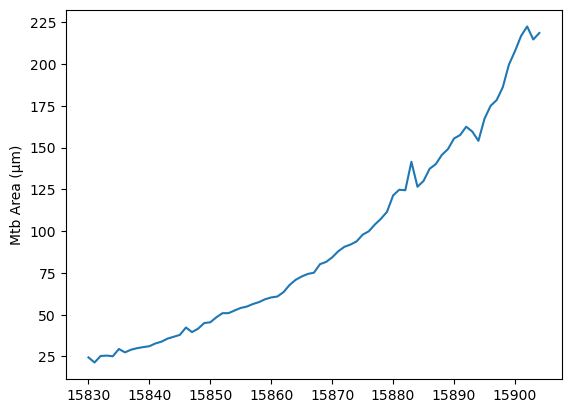

In [53]:
sns.lineplot(df[df['ID'] == '330.3.5.PS0000']['Mtb Area (µm)'])

In [38]:
df[(df['Acquisition ID'] == (5, 5)) & (df['Experiment ID'] == 'PS0000')]

,Time (hours),Mtb Area (µm),dMtb Area (µm),Mphi Area (µm),dMphi Area (µm),Infection Status,Initial Infection Status,Final Infection Status,x,y,...,Technical Replicate,Biological Replicate,Strain,Compound,Concentration,Cell ID,Acquisition ID,Experiment ID,Unique ID,ID
161037,0.0,0.000000,21.476872,688.310242,559.382006,0.0,0.0,1.0,603.374084,75.517464,...,3,1,WT,CTRL,EC0,430,"(5, 5)",PS0000,430.5.5,430.5.5.PS0000
161038,1.0,0.000000,21.476872,830.491211,559.382006,0.0,0.0,1.0,609.840881,72.468567,...,3,1,WT,CTRL,EC0,430,"(5, 5)",PS0000,430.5.5,430.5.5.PS0000
161039,2.0,0.000000,21.476872,828.859741,559.382006,0.0,0.0,1.0,609.223328,73.152298,...,3,1,WT,CTRL,EC0,430,"(5, 5)",PS0000,430.5.5,430.5.5.PS0000
161040,3.0,0.000000,21.476872,861.197998,559.382006,0.0,0.0,1.0,612.878601,75.968559,...,3,1,WT,CTRL,EC0,430,"(5, 5)",PS0000,430.5.5,430.5.5.PS0000
161041,4.0,0.000000,21.476872,781.324585,559.382006,0.0,0.0,1.0,620.689087,62.058659,...,3,1,WT,CTRL,EC0,430,"(5, 5)",PS0000,430.5.5,430.5.5.PS0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173257,70.0,75.242538,140.588154,592.234245,346.512905,1.0,0.0,1.0,329.958771,1058.050903,...,3,1,WT,CTRL,EC0,952,"(5, 5)",PS0000,952.5.5,952.5.5.PS0000
173258,71.0,100.200933,140.588154,656.821301,346.512905,1.0,0.0,1.0,330.624207,1053.126343,...,3,1,WT,CTRL,EC0,952,"(5, 5)",PS0000,952.5.5,952.5.5.PS0000
173259,72.0,125.397027,140.588154,716.424649,346.512905,1.0,0.0,1.0,330.173401,1053.920532,...,3,1,WT,CTRL,EC0,952,"(5, 5)",PS0000,952.5.5,952.5.5.PS0000
173260,73.0,144.780300,140.588154,780.430645,346.512905,1.0,0.0,1.0,331.492706,1052.608643,...,3,1,WT,CTRL,EC0,952,"(5, 5)",PS0000,952.5.5,952.5.5.PS0000
